In [1]:
import pandas as pd
import re
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score
import numpy as np
import evaluate


c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = pd.read_csv('dataset/sent_train.csv')
validation = pd.read_csv('dataset/sent_valid.csv')

In [3]:
def clean_tweet(text):
    text = re.sub(r'http\S+', '',text)
    text = re.sub(r'\$\w+', "",text)
    text = re.sub(r'@\w+',"", text)
    text = re.sub(r'[^a-zA-Z\s]','',text)
    return text.lower().strip()

In [4]:
train_data['clean_tweet'] = train_data['text'].apply(clean_tweet)
validation['clean_tweet'] = validation['text'].apply(clean_tweet)

print(train_data[['clean_tweet','label']].head())
print(train_data['label'].unique())

                                         clean_tweet  label
0      jpmorgan reels in expectations on beyond meat      0
1  nomura points to bookings weakness at carnival...      0
2  cemex cut at credit suisse jp morgan on weak b...      0
3                      btig research cuts to neutral      0
4            funko slides after piper jaffray pt cut      0
[0 1 2]


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=3)


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)


In [7]:
train_dataset = train_data[['text', 'label']].rename(columns={'text': 'text', 'label': 'labels'})
val_dataset = validation[['text', 'label']].rename(columns={'text': 'text', 'label': 'labels'})


train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)


train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])



Map: 100%|██████████| 2388/2388 [00:00<00:00, 18945.76 examples/s]


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Macro F1
1,No log,0.306577,0.848359
2,0.379500,0.284872,0.862233
3,0.379500,0.490370,0.850741
4,0.094400,0.609151,0.859031
5,0.094400,0.735800,0.859980


c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\Lenovo\.conda\envs\keras2env\lib\site-p

In [10]:
results = trainer.evaluate()
print("Final Macro-F1 on validation set:", results['eval_macro_f1'])


Final Macro-F1 on validation set: 0.8575853928655124


Using checkpoint: modernbert_2_checkpoints\checkpoint-1794
Loaded ModernBERT tokenizer


Map: 100%|██████████| 2388/2388 [00:00<00:00, 14550.95 examples/s]
c:\Users\Lenovo\.conda\envs\keras2env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Model loaded from modernbert_2_checkpoints\checkpoint-1794
Running evaluation...



Classification Report:
              precision    recall  f1-score      support
Bearish        0.827273  0.786744  0.806499   347.000000
Bullish        0.862144  0.829474  0.845494   475.000000
Neutral        0.913179  0.933589  0.923271  1566.000000
accuracy       0.891541  0.891541  0.891541     0.891541
macro avg      0.867532  0.849935  0.858421  2388.000000
weighted avg   0.890545  0.891541  0.890832  2388.000000


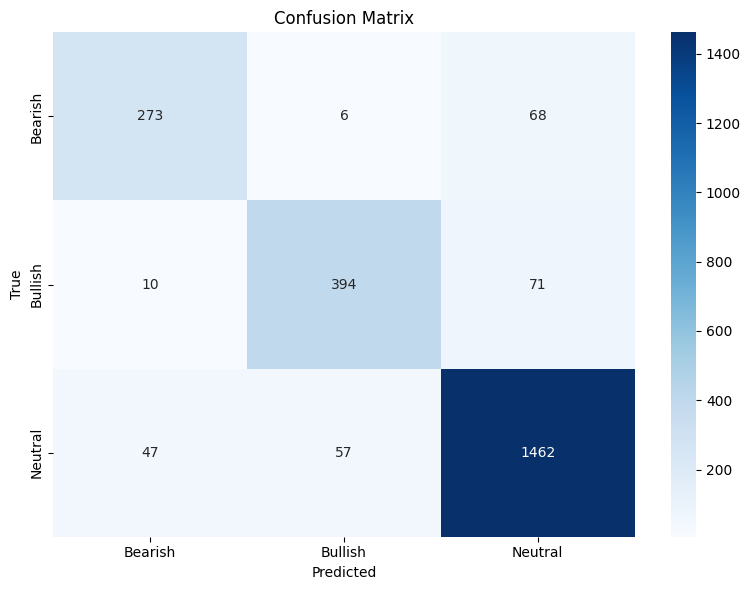

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23192\259172998.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true.numpy(), palette='viridis')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23192\259172998.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette='viridis')


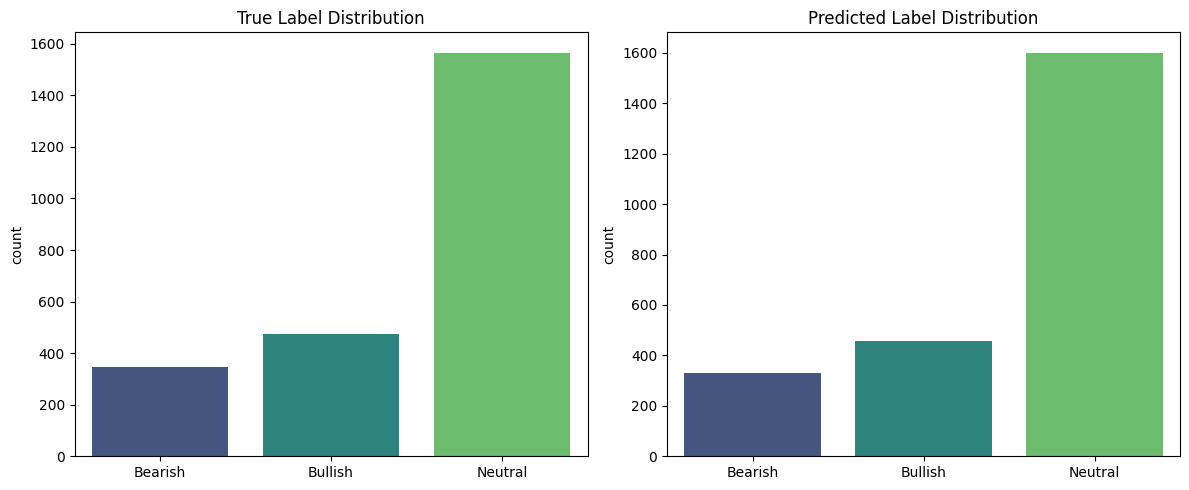


Evaluation Metrics:
Macro F1: 0.8584
Loss: 0.7307
F1 score for Bearish: 0.8065
F1 score for Bullish: 0.8455
F1 score for Neutral: 0.9233

Detailed results saved


In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datasets import Dataset



checkpoint_dir = "modernbert_2_checkpoints"


checkpoint_dirs = [os.path.join(checkpoint_dir, d) for d in os.listdir(checkpoint_dir) 
                   if os.path.isdir(os.path.join(checkpoint_dir, d)) and "checkpoint" in d]

if checkpoint_dirs:
    checkpoint_dirs.sort(key=lambda x: int(x.split("-")[-1]))
    best_checkpoint = checkpoint_dirs[-1]
    print(f"Using checkpoint: {best_checkpoint}")
else:
    best_checkpoint = checkpoint_dir
    print(f"No checkpoint subdirectories found. Using: {best_checkpoint}")

try:
    tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
    print("Loaded ModernBERT tokenizer")
except:
    try:
        tokenizer = AutoTokenizer.from_pretrained(best_checkpoint)
        print(f"Loaded tokenizer from {best_checkpoint}")
    except:
        tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
        print("Loaded fallback BERT tokenizer")

def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

val_dataset = validation[['text', 'label']].rename(columns={'text': 'text', 'label': 'labels'})
val_dataset = Dataset.from_pandas(val_dataset)
val_dataset = val_dataset.map(tokenize, batched=True)
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint)
print(f"Model loaded from {best_checkpoint}")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    f1 = f1_score(labels, predictions, average='macro')
    return {"macro_f1": f1}

training_args = TrainingArguments(
    output_dir="./modernBert_evaluation_output",
    per_device_eval_batch_size=32,
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
)

print("Running evaluation...")
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = val_dataset['labels']

print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=['Bearish', 'Bullish', 'Neutral'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

cm = confusion_matrix(y_true, y_pred)
labels = ['Bearish', 'Bullish', 'Neutral']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig('results/ModernBert_confusion_matrix.png')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_true.numpy(), palette='viridis')
plt.xticks([0, 1, 2], labels)
plt.title('True Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=y_pred, palette='viridis')
plt.xticks([0, 1, 2], labels)
plt.title('Predicted Label Distribution')

plt.tight_layout()
plt.savefig('results/ModernBert_label_distribution.png')
plt.show()

print("\nEvaluation Metrics:")
print(f"Macro F1: {predictions.metrics['test_macro_f1']:.4f}")
print(f"Loss: {predictions.metrics['test_loss']:.4f}")

from sklearn.metrics import f1_score
f1_per_class = f1_score(y_true, y_pred, average=None)
for i, label in enumerate(labels):
    print(f"F1 score for {label}: {f1_per_class[i]:.4f}")

results = {
    'Class': labels + ['macro avg', 'weighted avg'],
    'Precision': [report['Bearish']['precision'], report['Bullish']['precision'], 
                  report['Neutral']['precision'], report['macro avg']['precision'], 
                  report['weighted avg']['precision']],
    'Recall': [report['Bearish']['recall'], report['Bullish']['recall'], 
               report['Neutral']['recall'], report['macro avg']['recall'], 
               report['weighted avg']['recall']],
    'F1-Score': [report['Bearish']['f1-score'], report['Bullish']['f1-score'], 
                report['Neutral']['f1-score'], report['macro avg']['f1-score'], 
                report['weighted avg']['f1-score']],
    'Support': [report['Bearish']['support'], report['Bullish']['support'], 
                report['Neutral']['support'], report['macro avg']['support'], 
                report['weighted avg']['support']]
}

results_df = pd.DataFrame(results)
results_df.to_csv('results/modernBert_results.csv', index=False)
print("\nDetailed results saved")